In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- Load dataset ---
df = pd.read_csv("../data/classification_data_raw.csv")

features = ['income', 'per_college_educated_x', 'median_contract_rent']
X_raw = df[features]
y = df['gentrified']

# --- Train/test split before SMOTE ---
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

# --- Apply SMOTE to training data only ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Scale training and test data separately ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Use training scaler

# --- Base models ---
lr = LogisticRegression(
    penalty='l2', C=0.01, class_weight='balanced', max_iter=1000, random_state=42
)
rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)

# --- Final estimator ---
final_estimator = LogisticRegressionCV(
    cv=5, max_iter=10000, random_state=42
)

# --- Stacking classifier ---
stack_model = StackingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    final_estimator=final_estimator,
    passthrough=True
)

# --- Fit and evaluate ---
stack_model.fit(X_train_scaled, y_train_resampled)
y_pred = stack_model.predict(X_test_scaled)
y_prob = stack_model.predict_proba(X_test_scaled)[:, 1]

print("Stacked Model Performance:")
print(classification_report(y_test, y_pred))


Stacked Model Performance:
              precision    recall  f1-score   support

       False       0.98      0.90      0.94     38880
        True       0.07      0.29      0.11      1002

    accuracy                           0.88     39882
   macro avg       0.53      0.60      0.53     39882
weighted avg       0.96      0.88      0.92     39882



In [11]:
import pandas as pd

# Load the cleaned and MSA-merged forecasted data for 2035
df_2035 = pd.read_csv('../data/forecasted_data_2035_true.csv')

# Select the predictor variables used in the model
X = df_2035[['income_2035', 'college_2035', 'rent_2035']]

# Rename the columns to match the feature names expected by the model
# (Assumes `features` is a predefined list of expected feature names)
X.columns = features

# Apply the same scaler used during training to standardize the input data
scaled_data = scaler.transform(X)

# Predict the probability of gentrification using the trained ensemble model
# `predict_proba` returns probabilities for both classes [0, 1]; we select only the probability for class 1
pred_2035 = stack_model.predict_proba(scaled_data)[:, 1]

# Add the predicted probability as a new column to the original DataFrame
df_2035['gentrification_probability_2035'] = pred_2035

# Save the updated DataFrame to a CSV file for further analysis or visualization
df_2035.to_csv('../data/forecasted_probability_2035_ensemble.csv', index=False)

# Display the predicted probabilities (optional)
pred_2035


array([0.42045614, 0.12269195, 0.06291694, ..., 0.01326674, 0.00775305,
       0.01083538])

In [12]:
import pandas as pd

# Load the full forecasted dataset (includes multiple years)
df_2025 = pd.read_csv('../data/forecasted_data_2035.csv')

# Filter the dataset to include only data for the year 2025
df_2025 = df_2025[df_2025['year'] == 2025]

# Drop any rows with missing (NaN) values to ensure clean model input
df_2025 = df_2025.dropna()

# Remove any duplicate ZIP code entries to avoid repeated predictions
df_2025 = df_2025.drop_duplicates(subset=['zip_code'])

# Select the relevant features used for prediction
X = df_2025[['forecasted_income', 'forecasted_per_college_educated', 'forecasted_median_contract_rent']]

# Rename columns to match the feature names expected by the model
# (Assumes `features` is a predefined list used during model training)
X.columns = features

# Apply the same scaler used during model training to standardize the input data
scaled = scaler.transform(X)

# Use the trained ensemble model to predict gentrification probabilities for 2025
# `predict_proba` returns probabilities for both classes; [:, 1] selects probability of class 1 (gentrification)
pred_2025 = stack_model.predict_proba(scaled)[:, 1]

# Display the predicted probabilities for each ZIP code
pred_2025


array([0.0235288 , 0.02889408, 0.02615295, ..., 0.63978859, 0.00709519,
       0.00845877])

Threshold: 0.00 — Precision: 0.025, Recall: 1.000, F1: 0.049
Threshold: 0.05 — Precision: 0.049, Recall: 0.659, F1: 0.091
Threshold: 0.10 — Precision: 0.054, Recall: 0.547, F1: 0.099
Threshold: 0.15 — Precision: 0.057, Recall: 0.481, F1: 0.102
Threshold: 0.20 — Precision: 0.060, Recall: 0.443, F1: 0.105
Threshold: 0.25 — Precision: 0.062, Recall: 0.411, F1: 0.108
Threshold: 0.30 — Precision: 0.065, Recall: 0.388, F1: 0.111
Threshold: 0.35 — Precision: 0.067, Recall: 0.364, F1: 0.113
Threshold: 0.40 — Precision: 0.069, Recall: 0.342, F1: 0.114
Threshold: 0.45 — Precision: 0.069, Recall: 0.314, F1: 0.113
Threshold: 0.50 — Precision: 0.070, Recall: 0.293, F1: 0.114
Threshold: 0.55 — Precision: 0.072, Recall: 0.273, F1: 0.114
Threshold: 0.60 — Precision: 0.075, Recall: 0.254, F1: 0.116
Threshold: 0.65 — Precision: 0.077, Recall: 0.237, F1: 0.117
Threshold: 0.70 — Precision: 0.081, Recall: 0.219, F1: 0.118
Threshold: 0.75 — Precision: 0.082, Recall: 0.191, F1: 0.115
Threshold: 0.80 — Precis

/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


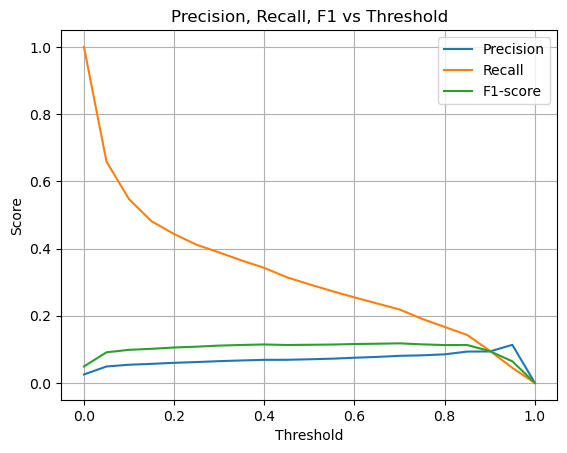

In [13]:
import numpy as np

# Create a range of threshold values from 0 to 1 in steps of 0.05
thresholds = np.arange(0, 1.05, 0.05)

from sklearn.metrics import precision_score, recall_score, f1_score

# Loop over each threshold to evaluate performance metrics
for thresh in thresholds:
    # Generate binary predictions using the current threshold
    y_pred_thresh = (y_prob >= thresh).astype(int)
    
    # Calculate precision, recall, and F1 score for these predictions
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    # Print the metrics for this threshold
    print(f"Threshold: {thresh:.2f} — Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Initialize lists to store the metric values across thresholds
precisions = []
recalls = []
f1s = []

# Repeat the threshold loop to populate the lists for plotting
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Plot each metric against the threshold
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')

# Add axis labels and a title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')

# Add legend and grid for readability
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


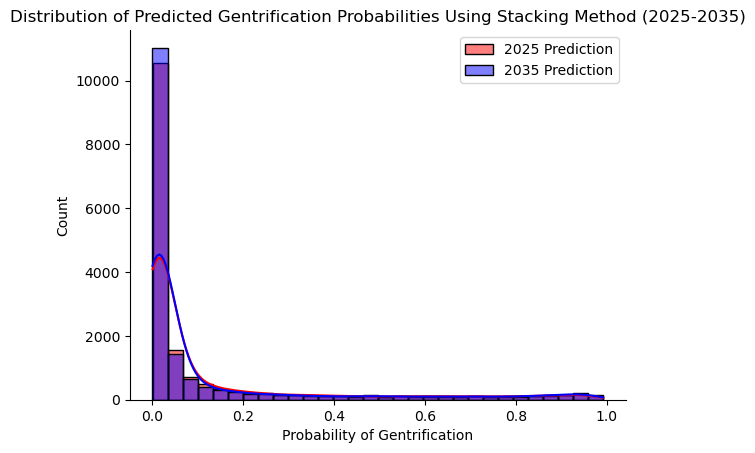

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a histogram of the 2025 gentrification probability predictions
# bins=30: Divide the range of probabilities into 30 bins
# alpha=0.5: Set transparency for better overlay visibility
# label='2025 Prediction': Label for the legend
# color='red': Color of the histogram
# kde=True: Add a kernel density estimate curve to show the distribution shape smoothly
sns.histplot(pred_2025, bins=30, alpha=0.5, label='2025 Prediction', color='red', kde=True)

# Plot a histogram of the 2035 gentrification probability predictions with similar settings but different color
sns.histplot(pred_2035, bins=30, alpha=0.5, label='2035 Prediction', color='blue', kde=True)

# Remove the top and right spines for a cleaner plot appearance
sns.despine()

# Optional: You had a commented-out line for 2031 predictions that can be enabled similarly
# sns.histplot(df_combined['gentrification_prob_2031'], bins=30, alpha=0.5, label='2031 Prediction', color='red', kde=True)

# Add a descriptive title to the plot
plt.title('Distribution of Predicted Gentrification Probabilities Using Stacking Method (2025-2035)')

# Label the x-axis to indicate what the numbers represent
plt.xlabel('Probability of Gentrification')

# Label the y-axis to indicate the count of ZIP codes in each bin
plt.ylabel('Count')

# Show the legend to identify each dataset's histogram
plt.legend()

# Display the final plot
plt.show()


In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

# Calculate the Area Under the Receiver Operating Characteristic Curve (ROC AUC)
# ROC AUC measures the ability of the model to distinguish between classes across all thresholds
auc = roc_auc_score(y_test, y_prob)

# Print the ROC AUC score
print("ROC AUC:", auc)

# Calculate the Area Under the Precision-Recall Curve (PR AUC)
# PR AUC is especially useful for imbalanced datasets and focuses on the tradeoff between precision and recall
print("PR AUC:", average_precision_score(y_test, y_prob))

# Compute the ROC curve values: False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
# These values can be used to plot the ROC curve and choose an optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)



ROC AUC: 0.7205626298842643
PR AUC: 0.06253949704097166


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


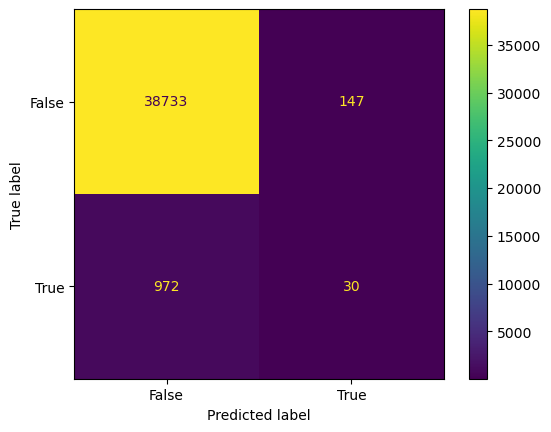

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix for the classification model using the test dataset
# This function uses the trained model (`stack_model`) to predict labels on `X_test`
# Then it compares predictions to true labels `y_test` to build the confusion matrix
ConfusionMatrixDisplay.from_estimator(stack_model, X_test, y_test)

# This visualization shows:
# - True Positives (correct positive predictions)
# - True Negatives (correct negative predictions)
# - False Positives (incorrect positive predictions)
# - False Negatives (incorrect negative predictions)


In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define a stratified K-Fold cross-validator
# This splits the data into 5 folds while preserving the percentage of samples for each class in y
# shuffle=True randomizes the data before splitting to avoid ordered bias
# random_state=42 ensures reproducibility of splits
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation to evaluate the model's F1 score on unseen data
# stack_model: the trained or to-be-trained ensemble model
# X_raw: feature matrix (raw/unscaled or as required by the model)
# y: target labels (binary classification)
# cv=kfold: use the defined stratified K-Fold splits
# scoring='f1': evaluate performance using the F1 score, which balances precision and recall
f1_scores = cross_val_score(stack_model, X_raw, y, cv=kfold, scoring='f1')

# Print the F1 scores obtained on each fold to see variability
print("Cross-validated F1 scores:", f1_scores)

# Print the average F1 score across all folds as an overall performance metric
print("Average F1 score:", np.mean(f1_scores))


Cross-validated F1 scores: [0.02287893 0.01342282 0.02285714 0.02480916 0.02091255]
Average F1 score: 0.020976120359888335


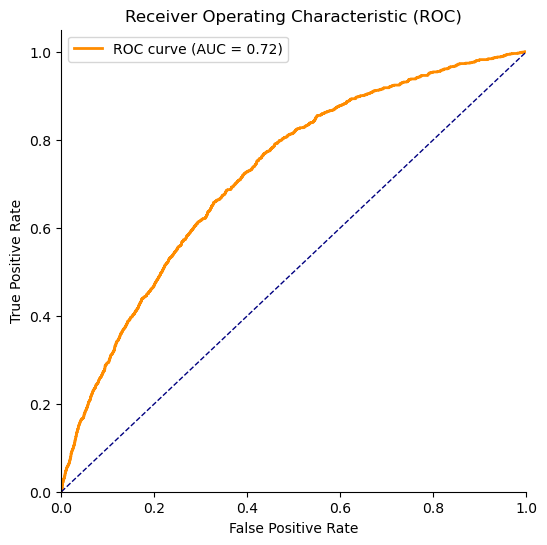

In [18]:
import matplotlib.pyplot as plt

# Create a figure and axes object with a 6x6 inch size for the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the ROC curve: TPR (y-axis) vs FPR (x-axis)
# 'darkorange' color, line width 2
# Label includes the AUC score formatted to 2 decimal places for the legend
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')

# Plot the diagonal dashed line representing a random classifier (no discrimination)
# This line goes from (0,0) to (1,1)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line

# Set the limits of the x-axis (False Positive Rate) from 0 to 1
ax.set_xlim([0.0, 1.0])

# Set the limits of the y-axis (True Positive Rate) from 0 to just above 1 for clarity
ax.set_ylim([0.0, 1.05])

# Label the x-axis
ax.set_xlabel('False Positive Rate')

# Label the y-axis
ax.set_ylabel('True Positive Rate')

# Set the plot title
ax.set_title('Receiver Operating Characteristic (ROC)')

# Display the legend in the upper left corner
ax.legend(loc="upper left")

# Remove the top and right border lines for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the final plot
plt.show()
